In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import numpy as np
import tensorflow as tf
import seaborn as sns
from datetime import datetime, timedelta

def plot_history(history, model_name="Two Towers"):
    # summarize history for loss
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.title(model_name + ' Model RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
    print("\n\nBest RMSE on validation : {0:.4f}".format(min(history.history['val_root_mean_squared_error'])))

In [ ]:
def normalize_ds(train_df, val_df, test_df):
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std

  return train_df, val_df, test_df, train_mean, train_std

In [ ]:
def plot_cor(df, figsize=(10, 8)):
  corr = df.corr()
  corr = np.abs(corr)
  fig, ax = plt.subplots(figsize=(10, 8))
  ax = sns.heatmap(corr, annot=False, ax=ax, cmap="Blues");
  ax.set_title("Correlation between Variables")

#### Load the data

In [ ]:
data_df = pd.read_csv('Data/Data_Alloprof_Processed.csv')
data_df.head()

,Date,Hour,Request_Nb_SMS,temps_comm_moy_SMS,temps_attente_moy_SMS,Request_Nb_Call,temps_comm_moy_Call,temps_attente_moy_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam
0,2021-08-02,9,2.0,206.0,4.0,0.0,0.0,0.0,1,0,1,0
1,2021-08-02,10,2.0,4930.0,136.0,0.0,0.0,0.0,1,0,1,0
2,2021-08-02,12,3.0,104.0,234.0,0.0,0.0,0.0,2,0,1,0
3,2021-08-02,13,1.0,4.0,4.0,0.0,0.0,0.0,1,0,1,0
4,2021-08-04,4,1.0,38.0,5.0,0.0,0.0,0.0,1,2,0,0


### Add additional time features to dataset

In [ ]:
def create_time_features_autoreg(df, features, labels=None):
  """
  Creates time series features from datetime index.
  """
  df = df.copy()
  df['Date_comp'] = df[['Date', 'Hour']].apply(lambda x: pd.to_datetime(x.Date) + timedelta(hours=int(x.Hour)), axis=1)
  df['Period'] = np.sin(2*np.pi* (df['Date_comp'].iloc[:] - df['Date_comp'].iloc[0]).dt.total_seconds()/(3600*24) + df['Date_comp'].iloc[0].hour/24)
  df['Month'] = df['Date_comp'].dt.month/12
  df['Year'] = df['Date_comp'].dt.year
  df.index = df['Date_comp']

  X = df[list(features) + ['Period', 'Month', 'Year']]
  if labels:
    y = df[labels]
    return X, y
  return X

In [ ]:
pred_by_day = False

proc_data_df = create_time_features_autoreg(data_df, data_df.columns, labels=None)

if(pred_by_day):
  col  = proc_data_df.columns[0:9]
  col2 = list(proc_data_df.columns[0:2]) + list(proc_data_df.columns[9:])
  proc_data_df.temps_comm_moy_SMS *= proc_data_df.Request_Nb_SMS
  proc_data_df.temps_attente_moy_SMS *= proc_data_df.Request_Nb_SMS
  proc_data_df.temps_comm_moy_Call *= proc_data_df.Request_Nb_Call
  proc_data_df.temps_attente_moy_Call *= proc_data_df.temps_attente_moy_Call

  _ = proc_data_df[col].groupby('Date').sum().copy()
  _.drop(columns=['Hour'], inplace=True)

  _.temps_comm_moy_SMS = _.temps_comm_moy_SMS//_.Request_Nb_SMS
  _.temps_attente_moy_SMS = _.temps_attente_moy_SMS//_.Request_Nb_SMS
  _.temps_comm_moy_Call = _.temps_comm_moy_Call//_.Request_Nb_Call
  _.temps_attente_moy_Call = _.temps_attente_moy_Call//_.Request_Nb_Call
  _.fillna(0, inplace=True)
  _[col2[2:]] = proc_data_df[col2].groupby('Date').max().drop(columns=['Hour'])[col2[2:]]
  proc_data_df = _
  proc_data_df.drop(columns=['Period'], inplace=True)
  proc_data_df.index = pd.to_datetime(proc_data_df.index)

else:
  proc_data_df.drop(columns=['Date', 'Hour'], inplace=True)
proc_data_df.head()

,Request_Nb_SMS,temps_comm_moy_SMS,temps_attente_moy_SMS,Request_Nb_Call,temps_comm_moy_Call,temps_attente_moy_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam,Period,Month,Year
Date_comp,,,,,,,,,,,,,
2021-08-02 09:00:00,2.0,206.0,4.0,0.0,0.0,0.0,1,0,1,0,0.366273,0.666667,2021
2021-08-02 10:00:00,2.0,4930.0,136.0,0.0,0.0,0.0,1,0,1,0,0.594625,0.666667,2021
2021-08-02 12:00:00,3.0,104.0,234.0,0.0,0.0,0.0,2,0,1,0,0.916962,0.666667,2021
2021-08-02 13:00:00,1.0,4.0,4.0,0.0,0.0,0.0,1,0,1,0,0.988980,0.666667,2021
2021-08-04 04:00:00,1.0,38.0,5.0,0.0,0.0,0.0,1,2,0,0,-0.804003,0.666667,2021


### Visualize Correlation between features

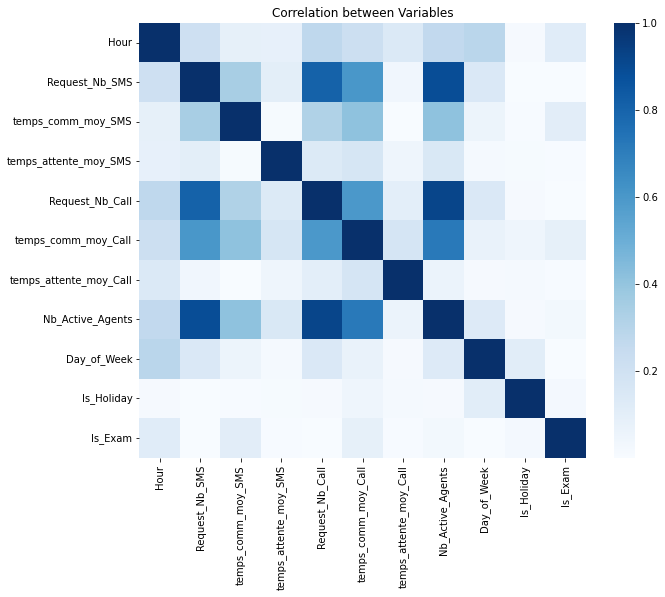

In [ ]:
plot_cor(data_df)

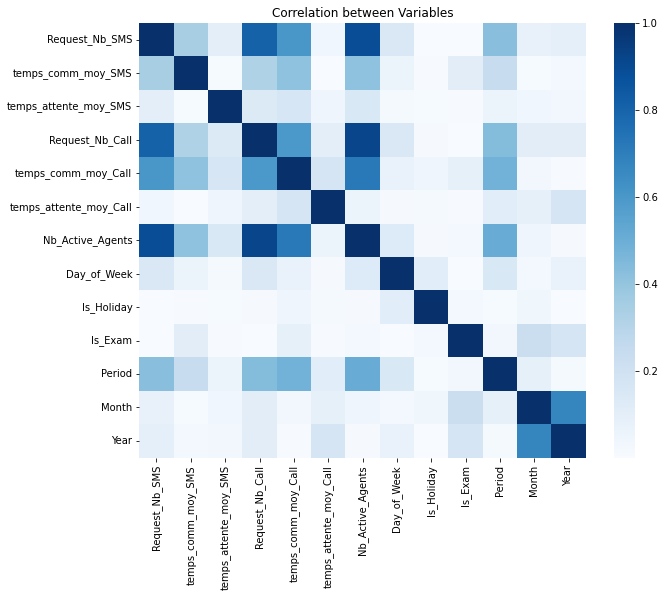

In [ ]:
plot_cor(proc_data_df)

In [ ]:
proc_data_df.dtypes

Request_Nb_SMS            float64
temps_comm_moy_SMS        float64
temps_attente_moy_SMS     float64
Request_Nb_Call           float64
temps_comm_moy_Call       float64
temps_attente_moy_Call    float64
Nb_Active_Agents            int64
Day_of_Week                 int64
Is_Holiday                  int64
Is_Exam                     int64
Period                    float64
Month                     float64
Year                        int64
dtype: object

### GBF Model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# sklearn.model_selection.train_test_split
label_columns = proc_data_df.columns[:7]

models = []
for feature in label_columns:
  X_train, X_test, y_train, y_test = train_test_split(proc_data_df.drop(columns=label_columns), proc_data_df[feature], test_size=0.2, random_state=42)

  param_test1 = {
      'n_estimators': 700,#range(300, 701, 100),
      'max_depth': 8,#range(4, 9, 2),
      'min_samples_leaf': 20,#range(10, 31, 10),
      'min_samples_split': 20#range(20, 51, 10)
  }
  reg = GradientBoostingRegressor(**param_test1)
  reg.fit(X_train, y_train)
  models.append(reg)

  mse = mean_squared_error(y_test, reg.predict(X_test))
  print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 105.6866
The mean squared error (MSE) on test set: 2993703.4750
The mean squared error (MSE) on test set: 34983382.5742
The mean squared error (MSE) on test set: 50.6307
The mean squared error (MSE) on test set: 28925.0970
The mean squared error (MSE) on test set: 7119.7598
The mean squared error (MSE) on test set: 5.7951


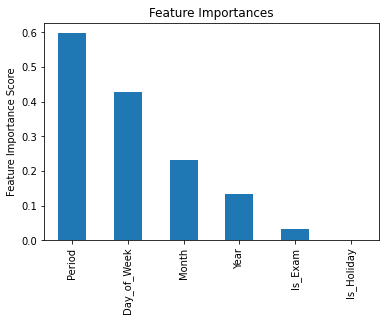

In [ ]:
for model in models:
  feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
  feat_imp.plot(kind='bar', title='Feature Importances')
  plt.ylabel('Feature Importance Score')
  plt.plot()

#### Ajout des timesteps qui manquent

In [ ]:
proc_data_dates_df = proc_data_df.asfreq('D') if pred_by_day else proc_data_df.asfreq('1h')
missing_dates = proc_data_dates_df[proc_data_dates_df['Request_Nb_SMS'].isna()].index
proc_data_dates_df.head(5)

,Request_Nb_SMS,temps_comm_moy_SMS,temps_attente_moy_SMS,Request_Nb_Call,temps_comm_moy_Call,temps_attente_moy_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam,Period,Month,Year
Date_comp,,,,,,,,,,,,,
2021-08-02 09:00:00,2.0,206.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.366273,0.666667,2021.0
2021-08-02 10:00:00,2.0,4930.0,136.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.594625,0.666667,2021.0
2021-08-02 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-02 12:00:00,3.0,104.0,234.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.916962,0.666667,2021.0
2021-08-02 13:00:00,1.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.988980,0.666667,2021.0


#### Analyzing missing values

In [ ]:
missing_dates_df = pd.DataFrame(missing_dates)
missing_dates_df['Year'] = missing_dates_df.Date_comp.dt.year
missing_dates_df['Month'] = missing_dates_df.Date_comp.dt.month
missing_dates_df['Week_of_Month'] = missing_dates_df.Date_comp.dt.day//7
missing_dates_df['Day'] = missing_dates_df.Date_comp.dt.day
missing_dates_df['Hour'] = missing_dates_df.Date_comp.dt.hour
missing_dates_df['counter'] = 1

missing_dates_df.head()

,Date_comp,Year,Month,Week_of_Month,Day,Hour,counter
0,2021-08-02 11:00:00,2021,8,0,2,11,1
1,2021-08-02 14:00:00,2021,8,0,2,14,1
2,2021-08-02 15:00:00,2021,8,0,2,15,1
3,2021-08-02 16:00:00,2021,8,0,2,16,1
4,2021-08-02 17:00:00,2021,8,0,2,17,1


In [ ]:
## Sanity Check
# _ = data_df[['Date', 'Hour']].apply(lambda x: pd.to_datetime(x.Date) + timedelta(hours=int(x.Hour)), axis=1)
# print(data_df[_.isin(missing_dates_df.Date_comp)].sum())
# proc_data_dates_df[proc_data_dates_df.index.isin(missing_dates_df.Date_comp)].sum()

<Axes: xlabel='Year,Month'>

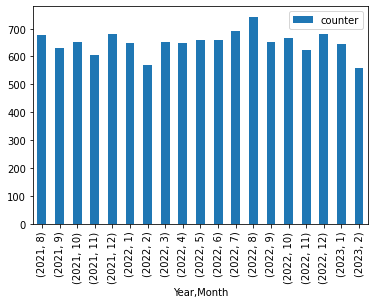

In [ ]:
missing_dates_df[['Year', 'Month', 'counter']].groupby(['Year', 'Month']).sum().plot.bar()

<Axes: xlabel='Day'>

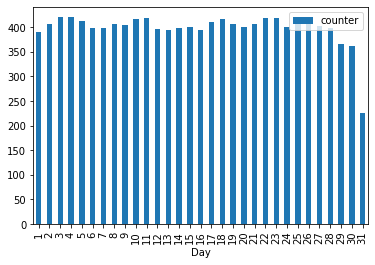

In [ ]:
## Heures manquantes par jour
missing_dates_df[['Day', 'counter']].groupby(['Day']).sum().plot.bar()

<Axes: xlabel='Hour'>

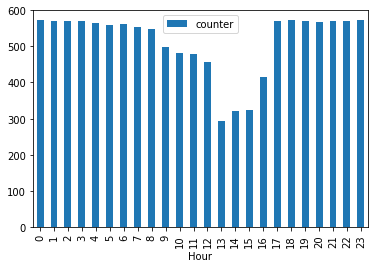

In [ ]:
missing_dates_df[['Hour', 'counter']].groupby(['Hour']).sum().plot.bar()

In [ ]:
missing_dates_df[['Hour', 'counter']].groupby(['Hour']).sum()

,counter
Hour,
0,572
1,569
2,571
3,570
4,564
5,558
6,563
7,553
8,548


In [ ]:
percentage_missing_data = (1-data_df.shape[0]/missing_dates.shape[0])*100
print('Pourcentage de données manquantes par heures est de {0:.2f}%.'.format(percentage_missing_data))

Pourcentage de données manquantes par heures est de 88.10%.


In [ ]:
agg_by_day = missing_dates_df.groupby(['Year', 'Month', 'Week_of_Month', 'Day']).sum()
_ = proc_data_dates_df.copy()
_['Week_of_Month'] = pd.to_datetime(_.index).day//7
_['Day'] = pd.to_datetime(_.index).day
_ = _.groupby(['Year', 'Month', 'Week_of_Month', 'Day']).sum()

print('Pourcentage de jours complets avec des données manquantes est de {0:.2f}%.'.format((agg_by_day==24).sum().counter/_.shape[0]*100))

Pourcentage de jours complets avec des données manquantes est de 65.99%.


## Prédictions des valeurs manquantes

In [ ]:
## Prédictions des valeurs manquantes grâce aux données historiques
proc_data_dates_interp_df = proc_data_dates_df.interpolate(method='time', order=3)
proc_data_dates_interp_df.head()

,Request_Nb_SMS,temps_comm_moy_SMS,temps_attente_moy_SMS,Request_Nb_Call,temps_comm_moy_Call,temps_attente_moy_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam,Period,Month,Year
Date_comp,,,,,,,,,,,,,
2021-08-02 09:00:00,2.0,206.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.366273,0.666667,2021.0
2021-08-02 10:00:00,2.0,4930.0,136.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.594625,0.666667,2021.0
2021-08-02 11:00:00,2.5,2517.0,185.0,0.0,0.0,0.0,1.5,0.0,1.0,0.0,0.755794,0.666667,2021.0
2021-08-02 12:00:00,3.0,104.0,234.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.916962,0.666667,2021.0
2021-08-02 13:00:00,1.0,4.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.988980,0.666667,2021.0


In [ ]:
proc_data_dates_interp_df.describe()

,Request_Nb_SMS,temps_comm_moy_SMS,temps_attente_moy_SMS,Request_Nb_Call,temps_comm_moy_Call,temps_attente_moy_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam,Period,Month,Year
count,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000,13799.000000
mean,18.097652,1124.801362,1135.514675,13.710595,370.535763,34.881586,10.540329,2.701754,0.016161,0.144829,0.590688,0.571850,2021.845532
std,17.391324,1021.899739,6527.161027,14.139993,316.480399,76.918763,9.014028,1.708691,0.103555,0.337256,0.425053,0.296819,0.570495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.993600,0.083333,2021.000000
25%,2.555556,255.049267,7.886154,0.891729,25.511905,1.714286,1.625000,1.274421,0.000000,0.000000,0.400469,0.274592,2021.242210
50%,12.190476,1095.492308,16.909091,9.545455,363.550000,15.800000,8.061538,2.500000,0.000000,0.000000,0.740007,0.666667,2022.000000
75%,30.325758,1770.196429,51.827468,23.614642,629.000000,37.705329,18.588558,4.045455,0.000000,0.000000,0.929863,0.833333,2022.000000
max,115.000000,25293.000000,84845.000000,76.000000,2171.000000,1583.000000,33.000000,6.000000,1.000000,1.000000,0.993600,1.000000,2023.000000


### Normaliser les données

In [ ]:
is_normalized = False
## Renormaliser après l'interpolation
if(is_normalized):
  mu = proc_data_dates_interp_df.mean()
  sigma = proc_data_dates_interp_df.std()

  proc_data_dates_interp_df = (proc_data_dates_interp_df - mu) / sigma

In [ ]:
mu, sigma

(Request_Nb_SMS              94.800347
 temps_comm_moy_SMS        1486.967882
 temps_attente_moy_SMS      277.401042
 Request_Nb_Call             76.781250
 temps_comm_moy_Call        543.467882
 temps_attente_moy_Call     348.305556
 Nb_Active_Agents            55.071181
 Day_of_Week                  2.705729
 Is_Holiday                   0.017361
 Is_Exam                      0.144965
 Month                        0.571470
 Year                      2021.846354
 dtype: float64, Request_Nb_SMS              60.184460
 temps_comm_moy_SMS         662.938639
 temps_attente_moy_SMS     2029.338269
 Request_Nb_Call             48.013093
 temps_comm_moy_Call        263.865843
 temps_attente_moy_Call    1536.581594
 Nb_Active_Agents            29.849460
 Day_of_Week                  1.877095
 Is_Holiday                   0.119064
 Is_Exam                      0.345323
 Month                        0.297069
 Year                         0.572444
 dtype: float64)

### Split Train, Val, Test

In [ ]:
proc_data_dates_interp_df.columns
proc_data_dates_interp_df = proc_data_dates_interp_df[['Request_Nb_SMS', 'Request_Nb_Call', 'Nb_Active_Agents', 'Day_of_Week', 'Is_Holiday', 'Is_Exam', 'Period', 'Month']]

In [ ]:
column_indices = {name: i for i, name in enumerate(proc_data_dates_interp_df.columns)}

BATCH_SIZE = 7 #if pred_by_day else 32
n = len(proc_data_dates_interp_df)

train_split, val_split = 0.7, 0.2
test_split = 1 - train_split - val_split

train_df = proc_data_dates_interp_df[0:int(n*train_split)]
val_df   = proc_data_dates_interp_df[int(n*train_split):int(n*(train_split+val_split))]
test_df  = proc_data_dates_interp_df[int(n*(1-test_split)):]

## Modèles

### Definitions des outils

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


  def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=BATCH_SIZE,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=0.01, clipnorm=1, epochs=MAX_EPOCHS):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=optimizer(learning_rate=lr, clipnorm=clipnorm),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### Modèle Linéaire Simple

17/17 [==============================] - 0s 2ms/step - loss: 0.5206 - root_mean_squared_error: 0.7215


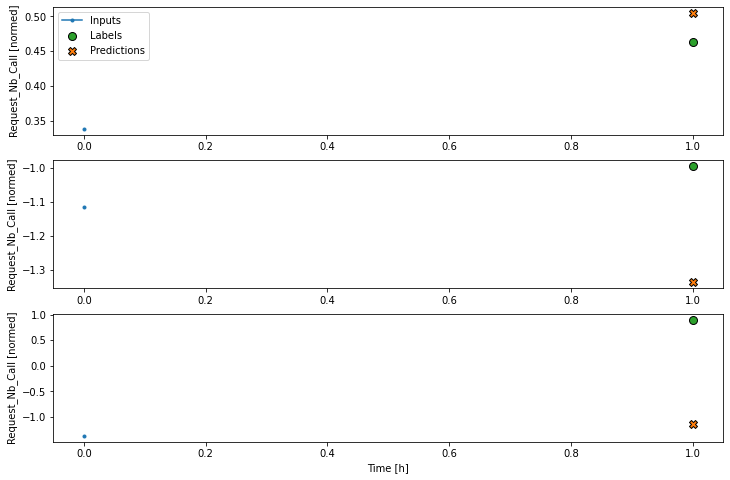

In [ ]:
num_features = train_df.shape[1]
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=num_features, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1)

lr=0.001

history_linear = compile_and_fit(linear, single_step_window, patience=5, lr=lr)

important_label = 'Request_Nb_Call'

IPython.display.clear_output()

linear.evaluate(single_step_window.val)
linear.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(linear, plot_col=important_label)

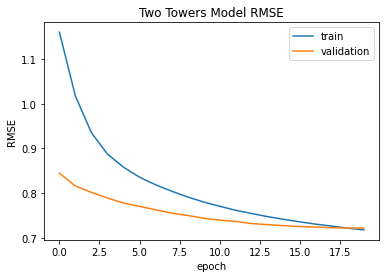



Best RMSE on validation : 0.7215


In [ ]:
plot_history(history_linear)

In [ ]:
single_step_window.train_df = single_step_window.val_df
compile_and_fit(linear, single_step_window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=lr, epochs=1)

17/17 [==============================] - 2s 27ms/step - loss: 0.5047 - root_mean_squared_error: 0.7104 - val_loss: 0.4798 - val_root_mean_squared_error: 0.6927


In [ ]:
single_step_window.train_df = single_step_window.test_df
compile_and_fit(linear, single_step_window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=lr, epochs=2)

Epoch 1/2
9/9 [==============================] - 1s 28ms/step - loss: 0.5432 - root_mean_squared_error: 0.7370 - val_loss: 0.4771 - val_root_mean_squared_error: 0.6908
Epoch 2/2
9/9 [==============================] - 0s 12ms/step - loss: 0.5033 - root_mean_squared_error: 0.7095 - val_loss: 0.4741 - val_root_mean_squared_error: 0.6886


In [ ]:
linear.evaluate(single_step_window.val)

17/17 [==============================] - 0s 2ms/step - loss: 0.4741 - root_mean_squared_error: 0.6886


[0.4741215705871582, 0.6885648369789124]

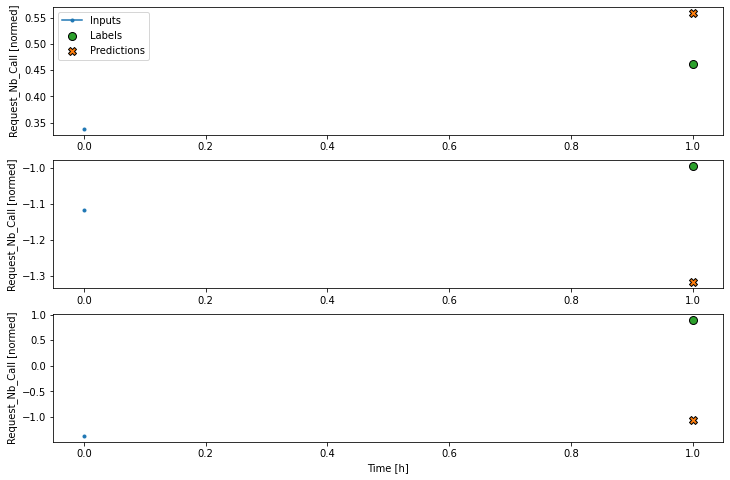

In [ ]:
single_step_window.plot(linear, plot_col=important_label)

In [ ]:
from tqdm import tqdm

if(pred_by_day):
  last_day = proc_data_dates_interp_df[-1:]
  x = np.expand_dims(last_day.to_numpy('float64'), 0)

  y_pred = linear(x)
  res = pd.DataFrame(data=(y_pred[0,:,:]*sigma + mu).numpy(), columns=train_df.columns)
  res.index = last_day.index

  last_day_df = res.copy()

  for i in tqdm(range(0, int(12*30.5))):
    y_pred = linear(y_pred)
    cur_res = pd.DataFrame(data=(y_pred[0,:,:]*sigma + mu).numpy(), columns=train_df.columns)

    cur_res.index  = res.index[-1:] + pd.to_timedelta('24h')
    res = pd.concat([res, cur_res])

  res = res.round(0)
  res[res<=0] = 0
  res.loc[res.Request_Nb_Call==0, ['temps_comm_moy_Call', 'temps_attente_moy_Call']] = 0
  res.loc[res.Request_Nb_SMS==0, ['temps_comm_moy_SMS', 'temps_attente_moy_SMS']] = 0
  res.tail(24)

100%|██████████| 366/366 [00:01<00:00, 192.77it/s]


<Axes: xlabel='Date'>

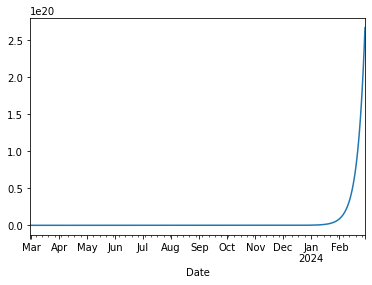

In [ ]:
res.Request_Nb_SMS.plot()

#### Modèle Autoregressif

In [ ]:
# num_features = len(label_columns)
num_features = train_df.shape[1]

class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.Sequential()
    self.dense.add(tf.keras.layers.Dense(units/2, activation="relu"))
    self.dense.add(tf.keras.layers.Dense(num_features))

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

  def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step.
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # Add the prediction to the output.
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


In [ ]:
OUT_STEPS = 24
shift     = OUT_STEPS
units     = 8

multi_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                               input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=shift)

feedback_model = FeedBack(units=units, out_steps=OUT_STEPS)
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

85/85 [==============================] - 1s 8ms/step - loss: 88.1529 - root_mean_squared_error: 9.3890


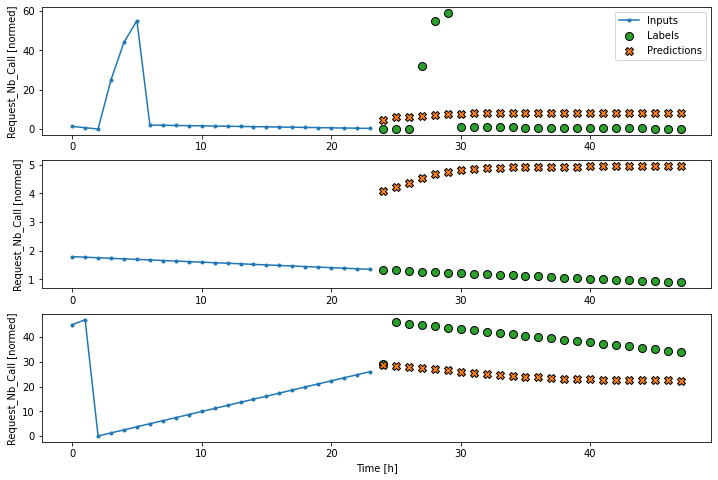

In [ ]:
label_columns   = train_df.columns[:7]
important_label = 'Request_Nb_Call'

lr = 0.001
feedback_history = compile_and_fit(feedback_model, multi_window, patience=5, lr=lr)

IPython.display.clear_output()

feedback_model.evaluate(multi_window.val)
feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col=important_label)

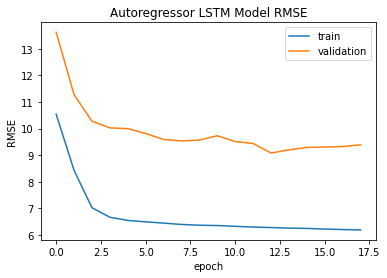



Best RMSE on validation : 9.0798


In [ ]:
plot_history(feedback_history, 'Autoregressor LSTM')

In [ ]:
multi_window.train_df = multi_window.val_df
compile_and_fit(feedback_model, multi_window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=lr, epochs=1)

85/85 [==============================] - 8s 31ms/step - loss: 75.8547 - root_mean_squared_error: 8.7095 - val_loss: 73.4528 - val_root_mean_squared_error: 8.5705


In [ ]:
multi_window.train_df = multi_window.test_df
compile_and_fit(feedback_model, multi_window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=lr, epochs=2)

Epoch 1/2
42/42 [==============================] - 7s 45ms/step - loss: 52.1495 - root_mean_squared_error: 7.2215 - val_loss: 87.9050 - val_root_mean_squared_error: 9.3758
Epoch 2/2
42/42 [==============================] - 1s 30ms/step - loss: 49.8826 - root_mean_squared_error: 7.0628 - val_loss: 89.3597 - val_root_mean_squared_error: 9.4530


In [ ]:
feedback_model.evaluate(multi_window.val)

85/85 [==============================] - 1s 7ms/step - loss: 89.3597 - root_mean_squared_error: 9.4530


[89.35966491699219, 9.453024864196777]

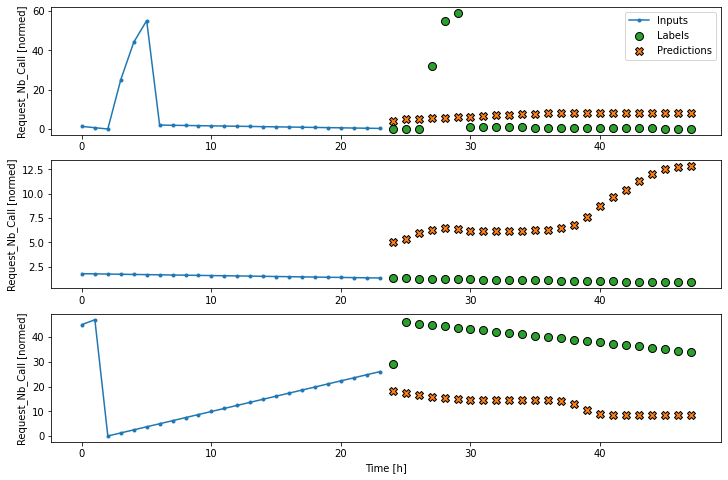

In [ ]:
multi_window.plot(feedback_model, plot_col=important_label)

In [ ]:
from tqdm import tqdm

if(not pred_by_day):
  last_day = proc_data_dates_interp_df[-24:]
  x = np.expand_dims(last_day.to_numpy('float64'), 0)

  y_pred = feedback_model(x)
  if(is_normalized):
    data_ready = (y_pred[0,:,:]*sigma + mu).numpy()
  else:
    data_ready = y_pred[0,:,:]

  res = pd.DataFrame(data=data_ready, columns=train_df.columns)
  res.index = last_day.index

  last_day_df = res.copy()

  for i in tqdm(range(0, int(12*30.5))):
    y_pred = feedback_model(y_pred)
    if(is_normalized):
      data_ready = (y_pred[0,:,:]*sigma + mu).numpy()
    else:
      data_ready = y_pred[0,:,:]
    cur_res = pd.DataFrame(data=data_ready, columns=train_df.columns)

    cur_res.index  = res.index[-24:] + pd.to_timedelta('24h')
    res = pd.concat([res, cur_res])

  res = res.round(0)
  res[res<=0] = 0
  res.loc[res.Request_Nb_Call==0, ['temps_comm_moy_Call', 'temps_attente_moy_Call']] = 0
  res.loc[res.Request_Nb_SMS==0, ['temps_comm_moy_SMS', 'temps_attente_moy_SMS']] = 0
  res.tail(24)

100%|██████████| 366/366 [00:40<00:00,  9.00it/s]


In [ ]:
res.head(800)

,Request_Nb_SMS,Request_Nb_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam,Period,Month,temps_comm_moy_Call,temps_attente_moy_Call,temps_comm_moy_SMS,temps_attente_moy_SMS
Date_comp,,,,,,,,,,,,
2023-02-27 08:00:00,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2023-02-27 09:00:00,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2023-02-27 10:00:00,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2023-02-27 11:00:00,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2023-02-27 12:00:00,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01 11:00:00,18.0,14.0,11.0,3.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN
2023-04-01 12:00:00,18.0,14.0,11.0,3.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN
2023-04-01 13:00:00,18.0,14.0,11.0,3.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
from tqdm import tqdm

if(pred_by_day):
  last_day = proc_data_dates_interp_df[-1:]
  x = np.expand_dims(last_day.to_numpy('float64'), 0)

  y_pred = feedback_model(x)
  res = pd.DataFrame(data=(y_pred[0,:,:]*sigma + mu).numpy(), columns=train_df.columns)
  res.index = last_day.index

  last_day_df = res.copy()

  for i in tqdm(range(0, int(12*30.5))):
    y_pred = feedback_model(y_pred)
    cur_res = pd.DataFrame(data=(y_pred[0,:,:]*sigma + mu).numpy(), columns=train_df.columns)

    cur_res.index  = res.index[-1:] + pd.to_timedelta('24h')
    res = pd.concat([res, cur_res])

  res = res.round(0)
  res[res<=0] = 0
  res.loc[res.Request_Nb_Call==0, ['temps_comm_moy_Call', 'temps_attente_moy_Call']] = 0
  res.loc[res.Request_Nb_SMS==0, ['temps_comm_moy_SMS', 'temps_attente_moy_SMS']] = 0
  res.tail(24)

100%|██████████| 366/366 [00:04<00:00, 84.43it/s]


In [ ]:
res.tail(24)

,Request_Nb_SMS,temps_comm_moy_SMS,temps_attente_moy_SMS,Request_Nb_Call,temps_comm_moy_Call,temps_attente_moy_Call,Nb_Active_Agents,Day_of_Week,Is_Holiday,Is_Exam,Month,Year
Date,,,,,,,,,,,,
2024-02-06,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-07,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-08,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-09,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-10,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-11,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-12,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-13,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0
2024-02-14,19.0,663.0,319.0,4.0,144.0,0.0,7.0,3.0,0.0,0.0,1.0,2022.0


### Inferring lstm

In [ ]:
num_features = len(label_columns)
multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns)


multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), activation=tf.keras.layers.LeakyReLU(0.01)),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


Epoch 1/20
301/301 [==============================] - 7s 16ms/step - loss: 0.7833 - root_mean_squared_error: 0.8851 - val_loss: 0.7225 - val_root_mean_squared_error: 0.8500
Epoch 2/20
301/301 [==============================] - 5s 16ms/step - loss: 0.6821 - root_mean_squared_error: 0.8259 - val_loss: 0.6963 - val_root_mean_squared_error: 0.8344
Epoch 3/20
301/301 [==============================] - 5s 15ms/step - loss: 0.6340 - root_mean_squared_error: 0.7963 - val_loss: 0.7141 - val_root_mean_squared_error: 0.8451
Epoch 4/20
85/85 [==============================] - 1s 7ms/step - loss: 0.7304 - root_mean_squared_error: 0.8546


ValueError: ignored

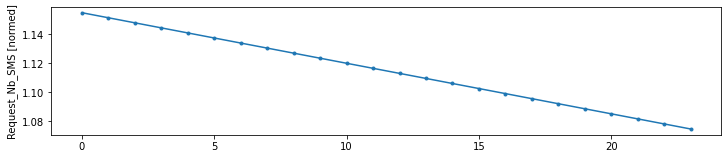

In [ ]:
lr=0.005

multi_lstm_history = compile_and_fit(multi_lstm_model, multi_window, patience=2, lr=lr)

# IPython.display.clear_output()

multi_lstm_model.evaluate(multi_window.val)
multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=label_columns[0])

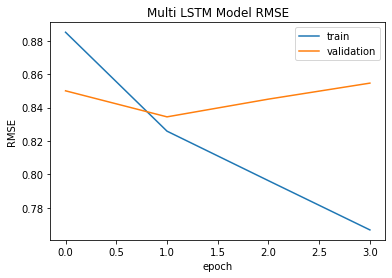



Best RMSE on validation : 0.8344


In [ ]:
plot_history(multi_lstm_history, model_name='Multi LSTM')

In [ ]:
multi_window.train_df = multi_window.val_df
lstm_hist = compile_and_fit(multi_lstm_model, multi_window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=lr, epochs=1)

85/85 [==============================] - 4s 24ms/step - loss: 0.5999 - root_mean_squared_error: 0.7745 - val_loss: 0.5488 - val_root_mean_squared_error: 0.7408


In [ ]:
multi_window.train_df = multi_window.test_df
lstm_hist = compile_and_fit(multi_lstm_model, multi_window, optimizer=tf.keras.optimizers.Adam, patience=2, lr=lr, epochs=2)

Epoch 1/2
42/42 [==============================] - 5s 34ms/step - loss: 0.5562 - root_mean_squared_error: 0.7458 - val_loss: 0.6457 - val_root_mean_squared_error: 0.8035
Epoch 2/2
42/42 [==============================] - 1s 27ms/step - loss: 0.5074 - root_mean_squared_error: 0.7123 - val_loss: 0.6341 - val_root_mean_squared_error: 0.7963


In [ ]:
x, y = next(iter(multi_window.val))
y_true = y[:,:, column_indices[important_label]]
y_pred = multi_lstm_model(x)[:,:, column_indices[important_label]]
tf.reduce_mean((y_pred*sigma[column_indices[important_label]]+mu[column_indices[important_label]] - y_true*sigma[column_indices[important_label]]+mu[column_indices[important_label]])**2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7488143>

In [ ]:
y_pred*sigma[column_indices[important_label]]+mu[column_indices[important_label]]

<tf.Tensor: shape=(32, 24), dtype=float32, numpy=
array([[ 9.53706086e-01,  1.08817625e+00,  1.09564650e+00,
         1.13681269e+00,  1.15151858e+00,  1.13988101e+00,
         1.12781131e+00,  1.11991954e+00,  1.11715555e+00,
         1.09663284e+00,  1.09205437e+00,  1.12706685e+00,
         1.13181210e+00,  1.10079551e+00,  1.05595899e+00,
         1.04408681e+00,  1.08692074e+00,  1.06312454e+00,
         9.93792057e-01,  9.14388895e-01,  8.97860050e-01,
         9.19129312e-01,  9.15598750e-01,  8.62736285e-01],
       [ 1.47063935e+00,  1.63765776e+00,  1.61505795e+00,
         1.54032409e+00,  1.52282929e+00,  1.52739215e+00,
         1.51308012e+00,  1.50705492e+00,  1.48835325e+00,
         1.44643605e+00,  1.46210229e+00,  1.45805383e+00,
         1.31084085e+00,  1.23886251e+00,  1.10835052e+00,
         1.09878612e+00,  1.08851278e+00,  1.05455279e+00,
         1.01115942e+00,  8.83113503e-01,  8.28662634e-01,
         7.07474530e-01,  5.22868872e-01,  4.79408950e-01],
    